# MLP in Tensorflow
This book will contain an implementation of MLP in tensorflow to classify handwritten digits from mnist dataset.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/home/kirito/anaconda3/envs/tensorflow-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Fetching MNIST 

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Displaying samples from MNIST 

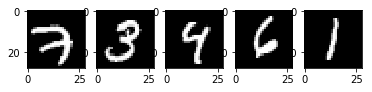

In [3]:
for index, image in enumerate(mnist.train.images[0:5]):
    plt.subplot(1,5,index+1)
    plt.imshow(image.reshape((28, 28)), cmap='gray')
    plt.draw()

### Sizes of Input, Output and Hidden Layers 

In [4]:
n_inputs = 784
n_outputs = 10
n_hidden_1 = 256
n_hidden_2 = 256

### Input and Output Placeholders 

In [5]:
batch_x = tf.placeholder(dtype=tf.float32, shape=[None, n_inputs], name="Batch_X")
batch_y = tf.placeholder(dtype=tf.float32, shape=[None, n_outputs], name="Batch_Y")

### Weights and Biases  

In [6]:
Wh1i = tf.Variable(tf.random_normal((n_inputs, n_hidden_1)), dtype=tf.float32, name="Wh1")
bh1 = tf.Variable(tf.random_normal((1, n_hidden_1)), dtype=tf.float32, name="Bh1")

Wh2h1 = tf.Variable(tf.random_normal((n_hidden_1, n_hidden_2)), dtype=tf.float32, name="Wh2")
bh2 = tf.Variable(tf.random_normal((1, n_hidden_2)), dtype=tf.float32, name="Bh2")

Woh2 = tf.Variable(tf.random_normal((n_hidden_2, n_outputs)), dtype=tf.float32, name="Wo")
bo = tf.Variable(tf.random_normal((1, n_outputs)), name="Bo")

### Tensor Operations
We are using ReLU as activation function and softmax at the final layer to get max probability.

In [7]:
with tf.name_scope("Layer_1"):
    zh1 = tf.add(tf.matmul(batch_x, Wh1i), bh1)
    # ah1 = tf.nn.tanh(zh1)
    # ah1 = tf.nn.relu(zh1)
    # ah1 = tf.nn.sigmoid(zh1)
    ah1 = zh1

with tf.name_scope("Layer_2"):
    zh2 = tf.add(tf.matmul(ah1, Wh2h1), bh2)
    # ah2 = tf.nn.tanh(zh2)
    # ah2 = tf.nn.relu(zh2)
    # ah2 = tf.nn.sigmoid(zh2)
    ah2 = zh2

with tf.name_scope("Layer_Output"):
    zo = tf.add(tf.matmul(ah2, Woh2), bo)
    # ao = tf.nn.tanh(zo)
    # ao = tf.nn.relu(zo)
    # ao = tf.nn.sigmoid(zo)
    ao = zo

In [8]:
logits = ao
prediction = tf.nn.softmax(ao)

In [10]:
with tf.name_scope("Loss"):
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=batch_y))
    tf.summary.scalar('Loss', loss_op)
with tf.name_scope("Train"):
    train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss_op)

### Number of training_steps 

In [11]:
training_epochs = 15
display_step = 10
batch_size = 100

### Initialize variables 

In [12]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
writer = tf.summary.FileWriter("/tmp/mnist_demo/1")

In [22]:
with tf.Session() as sess:
    # tensorboard settings
    merged_summary = tf.summary.merge_all()
    writer.add_graph(sess.graph)
    
    sess.run(init)
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            x, y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            s, _, c = sess.run([merged_summary, train_op, loss_op], feed_dict={batch_x: x, 
                                                         batch_y: y})
            writer.add_summary(s, i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
#     pred = tf.nn.softmax(logits)  # Apply softmax to logits
    with tf.name_scope("Test_accuracy"):
        correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(batch_y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        tf.summary.scalar('Accuracy', accuracy)
    print("Accuracy:", accuracy.eval({batch_x: mnist.test.images, batch_y: mnist.test.labels}))
    
    # save the trained model
    save_path = saver.save(sess, "/tmp/model-mnist.ckpt")

Epoch: 0001 cost=229.947110152
Epoch: 0011 cost=28.390103851
Optimization Finished!
Accuracy: 0.8826


### Run predictions 

In [18]:
import random

5,6,7,8,9,6,9,7,0,

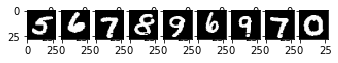

In [19]:
n_images = 10
start = random.randint(0, mnist.test.num_examples - n_images)
test_images = mnist.test.images[start:start + n_images - 1]
test_labels = mnist.test.labels[start:start + n_images - 1]
for idx, image in enumerate(test_images):
    image = np.reshape(image, (28, 28))
    print(np.argmax(test_labels[idx]), end=',')
    plt.subplot(1,n_images,idx+1)
    plt.imshow(image, cmap='gray')
    plt.draw()

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/model-mnist.ckpt")
    _logits = sess.run(logits, feed_dict={batch_x: test_images})
    _pred = tf.nn.softmax(_logits)
    predicted_number = tf.argmax(_pred, 1)
    _predicted_number = predicted_number.eval(feed_dict={batch_x: test_images})
    _actual_number = np.argmax(test_labels, 1)
    print('Predicted:',_predicted_number,'Actual:',_actual_number)

INFO:tensorflow:Restoring parameters from /tmp/model-mnist.ckpt
Predicted: [5 6 7 8 9 6 9 7 0] Actual: [5 6 7 8 9 6 9 7 0]
